<a href="https://colab.research.google.com/github/JonathanSum/AndroidProject/blob/master/Layer_Activations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Jonathan Sum

<img src="https://imgur.com/wniZTh0.jpg" width=300>

In [1]:

!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   322  100   322    0     0   1470      0 --:--:-- --:--:-- --:--:--  1470
Updating fastai...
Done.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from fastai import *
from fastai.vision import *

In [3]:
from fastai import version as fastai_version
print(f'fastai version -> {fastai_version.__version__}')

fastai version -> 1.0.60


In [0]:
bs = 32  #batch size

In [0]:
!cp "/content/drive/My Drive/color1.7z" "/content"

In [8]:
!p7zip -d /content/color1.7z

/usr/bin/p7zip: cannot read /content/color1.7z


In [0]:
!cp "/content/drive/My Drive/other_chars_repaired.7z" "/content/"

In [10]:
!mv "/content/other_chars.7z_repaired" "/content/other_chars.7z"

mv: cannot stat '/content/other_chars.7z_repaired': No such file or directory


In [12]:
!p7zip -d /content/other_chars_repaired.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 247288608 bytes (236 MiB)

Extracting archive: /content/other_chars_repaired.7z
--
Path = /content/other_chars_repaired.7z
Type = 7z
Physical Size = 247288608
Headers Size = 2410
Method = LZMA2:24
Solid = +
Blocks = 1

  0%     48% 76 - other_chars/aunt (43).png                                    80% 129 - other_chars/taiyo (21).png                                     Everything is Ok

Folders: 1
Files: 161
Size:       247374770
Compressed: 247288608


In [0]:
!mv /content/other_chars/* /content/data/happy_sugar_life/color

In [0]:
path = Path('data/happy_sugar_life')

path.mkdir(parents=True, exist_ok=True)

In [0]:
!mv "/content/color" "/content/data/happy_sugar_life"

In [649]:
len(get_files(Path("/content/data/happy_sugar_life/color")))

923

In [0]:
path_img = path/'color'
file1 = fnames[0]


In [0]:
pat = r'/([^/]+)\s[(]\d+[)](.jpg|.png|.jpeg)$'
fnames = get_image_files(path_img)
bs = 64


In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=350, bs=bs
                                  ).normalize(imagenet_stats)

In [0]:
# !cd data/happy_sugar_life/color
rm -rf vlcsnap*     #delete any file starting with vlc

In [31]:
ls

/root/.fastai


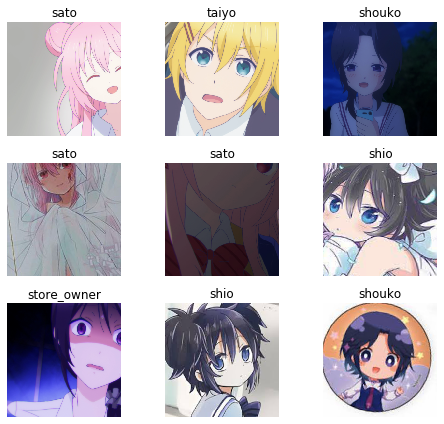

In [74]:
data.show_batch(rows=3, figsize=(7,6))

In [411]:
print(data.classes)
len(data.classes),data.c

['asahi', 'aunt', 'daichi', 'sato', 'shio', 'shouko', 'store_owner', 'sumire', 'taiyo', 'yuna']


(10, 10)

In [0]:
rm -r /content/data/happy_sugar_life/color

In [0]:
bs = 32  #batch size

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [132]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.874906,1.352466,0.382514,05:14
1,1.783394,0.577476,0.169399,05:15
2,1.280343,0.402665,0.120219,05:15
3,1.007078,0.372020,0.092896,05:12


In [0]:
learn.save('stage-1')

In [385]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

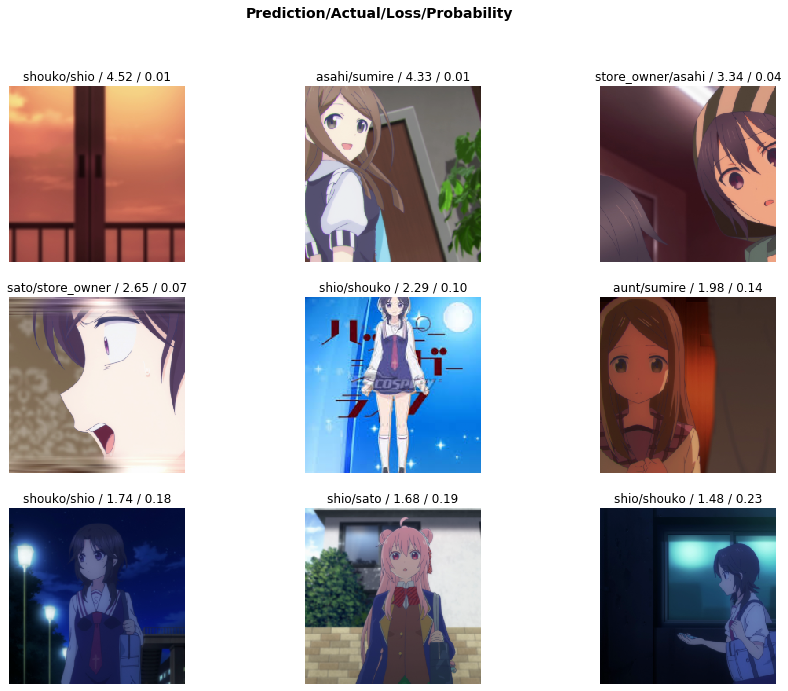

In [386]:
interp.plot_top_losses(9, figsize=(15,11))

In [389]:
doc(interp.plot_top_losses)

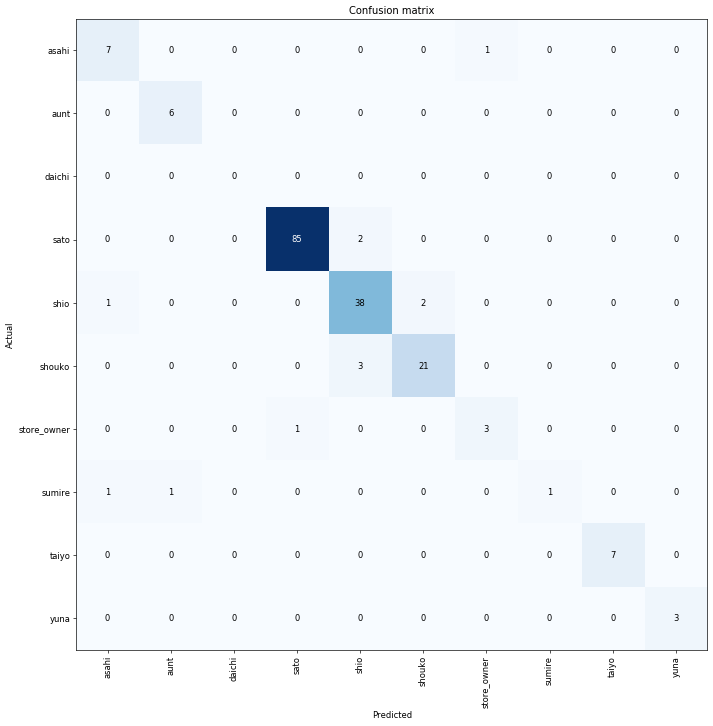

In [390]:

interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [391]:
interp.most_confused(min_val=2)

[('shouko', 'shio', 3), ('sato', 'shio', 2), ('shio', 'shouko', 2)]

In [140]:
learn.unfreeze()
learn.fit_one_cycle(1)

learn.load('stage-1');

epoch,train_loss,valid_loss,error_rate,time
0,0.519617,0.643032,0.136612,07:10


In [141]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


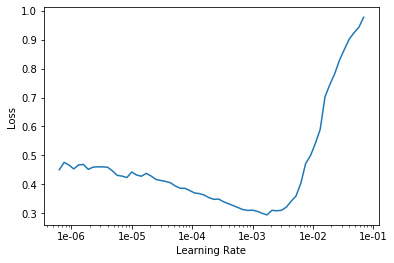

In [142]:
learn.recorder.plot()

In [143]:

learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.453216,0.360366,0.098361,07:04
1,0.388186,0.344992,0.103825,07:04


In [144]:
learn.save('ten-sat-classif', return_path=True)

PosixPath('data/happy_sugar_life/color/models/ten-sat-classif.pth')

In [0]:
learn.load('ten-sat-classif')

In [0]:
!cp "data/happy_sugar_life/color/models/ten-sat-classif.pth" "/content/drive/My Drive/ten-sat-classif.pth"

In [0]:
learn.export()

In [0]:
learn2 = load_learner(path =Path("/content/drive/My Drive/"))

In [0]:
!cp "data/happy_sugar_life/color/export.pkl" "/content/drive/My Drive/ten-sat-classif.pkl"

class name: sato
class_index: 3


fastai.vision.image.Image

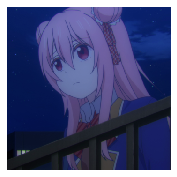

In [724]:
idx=61
x,y = data.valid_ds[idx]
x.show()
print(f'class name: {y}\nclass_index: {y.data}')
type(x)

In [0]:
from fastai.callbacks.hooks import *
m = learn.model.eval();
requires_grad(m, False)

In [0]:
t1 = torch.load("/content/drive/My Drive/ten-sat-classif.pth")

In [0]:
x = open_image("/content/tyu.png")

In [0]:
# x

In [0]:
xb,_ = data.one_item(x)    #get tensor from Image x
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [0]:
def non_class_discriminative_activations_multi(xb):
    hooks = []
    layer_names = []
    
    hooks.append(hook_output(m[0][3]))
    layer_names.append('first conv')

    for ind in [4,5,6,7]:
        for i,el in enumerate(learn.model[0][ind]):
            hooks.append(hook_output(el))
            layer_names.append(f'layer-{ind-3} - conv-{i+1}')
            #model[0][3] is the first cnn, then [0][4]
    
    preds = m(xb)
    
    for hook in hooks:
        hook.remove()
    
    return hooks,layer_names

In [0]:
hooks,layer_names = non_class_discriminative_activations_multi(xb)

In [752]:
xb.shape

torch.Size([1, 3, 350, 350])

In [753]:
for layer_name,hook in zip(layer_names,hooks):
    print(f'{layer_name}{" "*(18-len(layer_name))} -->   {hook.stored[0].shape}')

first conv         -->   torch.Size([64, 88, 88])
layer-1 - conv-1   -->   torch.Size([64, 88, 88])
layer-1 - conv-2   -->   torch.Size([64, 88, 88])
layer-1 - conv-3   -->   torch.Size([64, 88, 88])
layer-2 - conv-1   -->   torch.Size([128, 44, 44])
layer-2 - conv-2   -->   torch.Size([128, 44, 44])
layer-2 - conv-3   -->   torch.Size([128, 44, 44])
layer-2 - conv-4   -->   torch.Size([128, 44, 44])
layer-3 - conv-1   -->   torch.Size([256, 22, 22])
layer-3 - conv-2   -->   torch.Size([256, 22, 22])
layer-3 - conv-3   -->   torch.Size([256, 22, 22])
layer-3 - conv-4   -->   torch.Size([256, 22, 22])
layer-3 - conv-5   -->   torch.Size([256, 22, 22])
layer-3 - conv-6   -->   torch.Size([256, 22, 22])
layer-4 - conv-1   -->   torch.Size([512, 11, 11])
layer-4 - conv-2   -->   torch.Size([512, 11, 11])
layer-4 - conv-3   -->   torch.Size([512, 11, 11])


In [754]:
acts = hooks[1].stored[0].cpu()
acts.shape

torch.Size([64, 88, 88])

Averaging the values of these activations over the channel axis to get a 2 dimensional tensor.

In [755]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([88, 88])

Plotting these averaged activations.

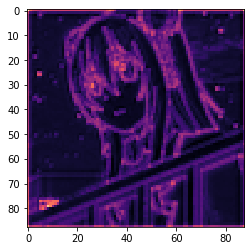

In [756]:
plt.imshow(avg_acts, cmap='magma');

In [0]:
from math import ceil

In [0]:
def plot_forward_activations_multi(hooks):
    
    num_cols = 4
    num_rows = ceil(len(hooks)/num_cols)

    fig,ax = plt.subplots(num_rows,num_cols)
    fig.set_size_inches(num_cols*3,num_rows*3)

    ind = 0
    
    for i in range(num_rows):
        for j in range(num_cols):
            
            if ind>=len(hooks):
                break
            
            acts  = hooks[ind].stored[0].cpu()
            avg_acts = acts.mean(0)

            ax[i,j].imshow(avg_acts, cmap='magma')
            ind+=1
            
    plt.show()

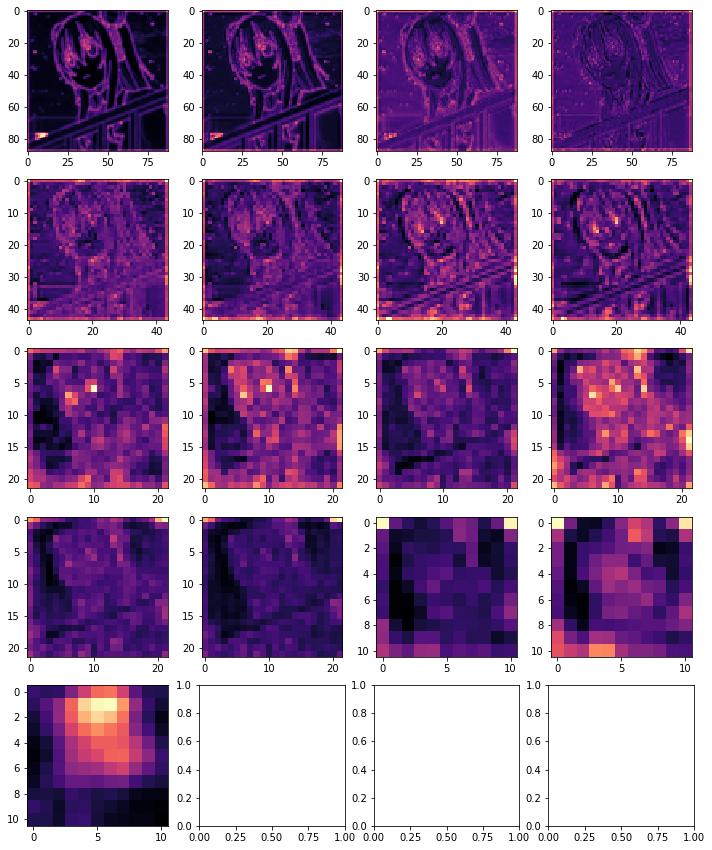

In [736]:
plot_forward_activations_multi(hooks)

In [0]:
def plot_non_class_discriminative_heatmaps_multi(x):
    
    xb,_ = data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    
    hooks,_ = non_class_discriminative_activations_multi(xb)
    
    num_cols = 4
    num_rows = ceil(len(hooks)/num_cols)

    fig,ax = plt.subplots(num_rows,num_cols)
    fig.set_size_inches(num_cols*3,num_rows*3)

    ind = 0
    
    for i in range(num_rows):
        for j in range(num_cols):
            
            if ind>=len(hooks):
                break
            
            acts  = hooks[ind].stored[0].cpu()
            avg_acts = acts.mean(0)

            xb_im.show(ax[i,j])
            ax[i,j].imshow(avg_acts, alpha=0.6, extent=(0,350,350,0),
                      interpolation='bilinear', cmap='magma');
            ind+=1
            
    plt.show()

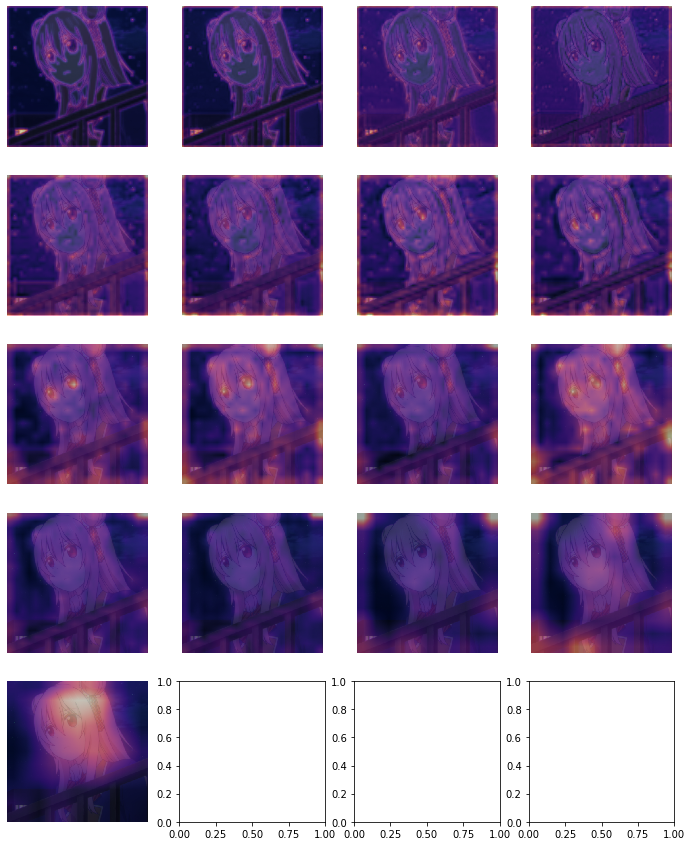

In [737]:
plot_non_class_discriminative_heatmaps_multi(x)

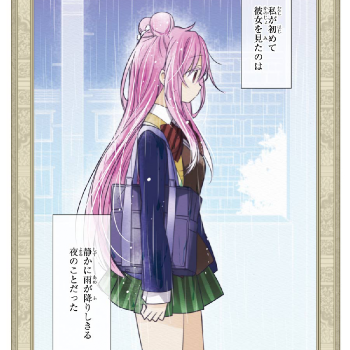

In [686]:
img1 = open_image(Path("/content/tyu.png"))
x

In [687]:

learn.predict(x)


(Category sato,
 tensor(3),
 tensor([4.7618e-05, 9.8213e-04, 7.5764e-04, 9.9248e-01, 1.8865e-03, 1.3782e-03,
         4.6056e-04, 1.9685e-04, 1.1934e-03, 6.1904e-04]))